# Boulder 2016 B-cycle Trip Data Exploration

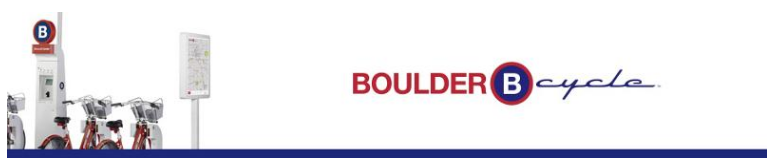

In [1]:
from IPython.display import Image
image = Image('figures/Boulder Header.png')
image

## 1. Introduction

[Boulder B-cycle](https://boulder.bcycle.com/) is a nonprofit organization formed by Boulder residents to create and operate Boulder’s bike-sharing program on a not-for-profit, financially sustainable basis. Its mission is to “implement and operate a community-supported bike-share program that provides Boulder’s residents, commuters and visitors with an environmentally friendly, financially sustainable, and affordable transportation option that’s ideal for short trips resulting in fewer vehicle miles traveled, less pollution and congestion, more personal mobility and better health and wellness.”

## 2. The Datasets

The dataset is in an Excel .xlsx format and is a 30 MB file. It contains data from May 2011 to January 2017. For the purpose of this exercise only rows for 2016 were kept.

In [2]:
# import necessary libraries and modules
import pandas as pd
import numpy as np
from numpy import datetime64
import csv
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [3]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('data/style-table.css').read() + open('data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
# read converted csv compressed file
dF = pd.read_csv("data/2016_Boulder_Bike_Trip_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

### Trips dataframe data structure

Trips dataframe has 11 columns, two int64 and 10 object data types. The column names were updated in 
Boulder_2016_Excel_to_CSV_File_Conversion.ipynb
The original columns in the Excel file were ('Rider Home System' , 'Rider or Operator Number', 'Entry Pass Type',
'Bike Number', 'Checkout Date', 'Checkout Day of Week', 'Checkout Time', 'Checkout Station', 'Return Date',
'Return Day of Week', 'Return Time', 'Return Station', 'Trip Duration (Minutes)')

In [5]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113728 entries, 0 to 113727
Data columns (total 11 columns):
User_Program       113728 non-null object
User_ID            113728 non-null object
Membership_Type    113726 non-null object
Bike_Number        113728 non-null object
Checkout_Date      113728 non-null object
Checkout_Time      113728 non-null object
Checkout_Kiosk     113728 non-null object
Return_Date        113728 non-null object
Return_Time        113728 non-null object
Return_Kiosk       113726 non-null object
Trip_Duration      113728 non-null int64
dtypes: int64(1), object(10)
memory usage: 9.5+ MB


### Estimated number of trips = 113,728

In [6]:
# main dataframe has 113,728 rows of data
dF.shape

(113728, 11)

### Remove rows with NULL values in ANY column

In [7]:
dF.isnull().values.any()

True

In [8]:
nan_rows = dF[dF.isnull().T.any().T]

In [9]:
nan_rows

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration
102398,Boulder B-cycle,R1016765,Maintenance,539,2016-11-03,08:36:00,30th & Marine,00:00:00,00:00:00,NaN,0
103396,Pacers Bikeshare,R1061304,NaN,169,2016-11-05,14:03:00,15th & Pearl,2016-11-05 00:00:00,14:03:00,15th & Pearl,0
103397,Pacers Bikeshare,R1061304,NaN,169,2016-11-05,14:03:00,15th & Pearl,2016-11-05 00:00:00,14:03:00,15th & Pearl,0
113662,Boulder B-cycle,M9999920,Maintenance,7,2016-12-31,11:35:00,The Village,00:00:00,00:00:00,NaN,0


In [10]:
dF = dF.drop(dF.index[nan_rows.index])

### Estimated number of trips = 113,724

In [11]:
dF.shape

(113724, 11)

In [12]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,00:48:00,15th & Pearl,2016-01-01 00:00:00,01:10:00,UCAR Mitchell Lane,22
1,Boulder B-cycle,R1055645,Annual,578,2016-01-01,04:08:00,26th @ Pearl,2016-01-01 00:00:00,04:17:00,14th & Canyon,9
2,Boulder B-cycle,R1070183,Annual,763,2016-01-01,09:56:00,38th & Arapahoe,2016-01-01 00:00:00,10:10:00,Municipal Building,14


### Convert Checkout_Date and Return_Date columns to DateTime datatype

In [13]:
dF['Checkout_Date'] = pd.to_datetime(dF['Checkout_Date'])
dF['Return_Date'] = pd.to_datetime(dF['Return_Date'])

In [14]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,00:48:00,15th & Pearl,2016-01-01,01:10:00,UCAR Mitchell Lane,22
1,Boulder B-cycle,R1055645,Annual,578,2016-01-01,04:08:00,26th @ Pearl,2016-01-01,04:17:00,14th & Canyon,9
2,Boulder B-cycle,R1070183,Annual,763,2016-01-01,09:56:00,38th & Arapahoe,2016-01-01,10:10:00,Municipal Building,14


## 3. Data Wrangling

### Filtering the main dataframe to obtain actual miles ridden

### Checkouts Per Membership Type

In [15]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)

In [16]:
# there are 15,456 rows with Membership = Maintenance, a significant 13.6%
membership.head(10)

Membership_Type
Annual                57042
24-hour               28948
Maintenance           15454
Monthly               10961
Pay-per-trip            853
Semester (150-day)      465
7-day                     1
dtype: int64

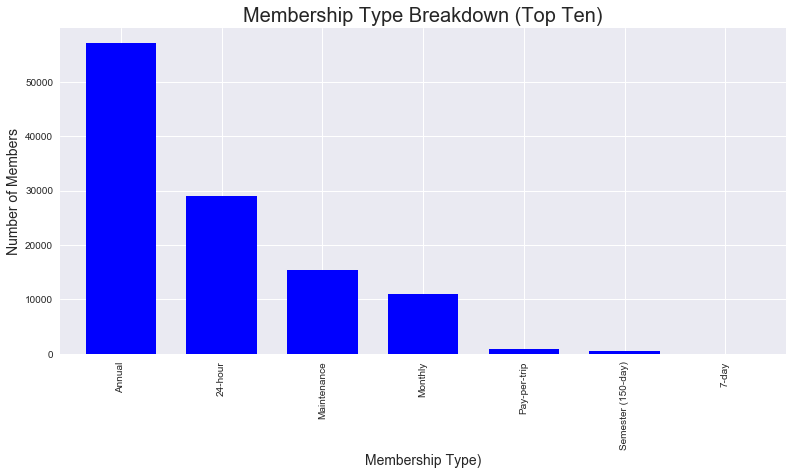

In [17]:
# plot the results
ax = dF.groupby('Membership_Type').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Membership Type Breakdown (Top Ten)', fontsize = 20)
plt.xlabel('Membership Type)', fontsize = 14)
plt.ylabel('Number of Members', fontsize = 14)
plt.show()

In [18]:
# cannot use "Maintenance" to count toward total distance ridden
dF = dF[dF.Membership_Type != 'Maintenance']

### Estimated number of trips = 98,270

In [19]:
dF.shape

(98270, 11)

### Keep a copy of the dataframe for use in Regression and Classification studies

In [20]:
dML = dF.copy(deep=True)

In [21]:
# Check to see number of trips made with 0 minutes
tripDurZero = dF[(dF['Trip_Duration'] == 0)]
tripDurZero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 5 to 113721
Data columns (total 11 columns):
User_Program       2169 non-null object
User_ID            2169 non-null object
Membership_Type    2169 non-null object
Bike_Number        2169 non-null object
Checkout_Date      2169 non-null datetime64[ns]
Checkout_Time      2169 non-null object
Checkout_Kiosk     2169 non-null object
Return_Date        2169 non-null datetime64[ns]
Return_Time        2169 non-null object
Return_Kiosk       2169 non-null object
Trip_Duration      2169 non-null int64
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 203.3+ KB


In [22]:
# cannot use Trip Duration = 0 to count toward total distance ridden
dF = dF[dF.Trip_Duration != 0]

### Estimated number of trips = 96,101

In [23]:
dF.shape

(96101, 11)

In [24]:
# Check to see number of trips made with 1 minute
tripDurOne = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Duration"] == 1)]
tripDurOne.shape

(1343, 11)

In [25]:
# Check to see number of trips made with 15 minutes or less
dX = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Duration"] < 16)]
dX.shape

(3343, 11)

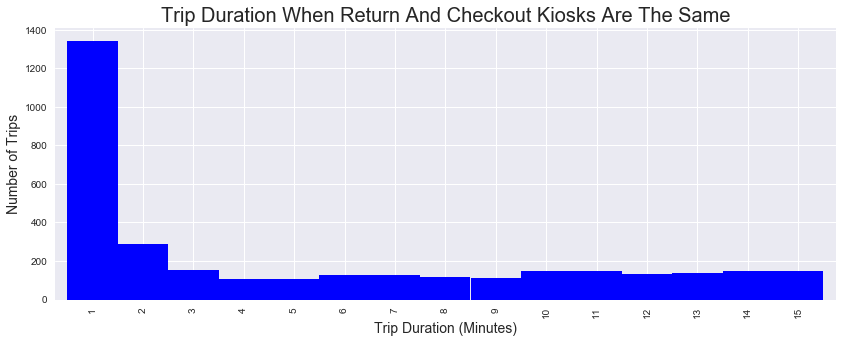

In [26]:
# plot the results
ax = dX.groupby('Trip_Duration').size().plot(kind='bar', figsize=(14,5), color='blue', width=1.0, xlim=(0,16))
plt.title('Trip Duration When Return And Checkout Kiosks Are The Same', fontsize = 20)
plt.xlabel('Trip Duration (Minutes)', fontsize = 14)
plt.ylabel('Number of Trips', fontsize = 14)
plt.show()

### Estimated number of trips = 94,512

In [27]:
# remove rows that have a trip duration of 1 minute
dF.drop(dF[dF['Trip_Duration'] == 1].index, inplace = True)

In [28]:
# main dataframe has 94,512 rows to work with, a reduction of 10,115 data rows
dF.shape

(94512, 11)

In [29]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)
membership.head(10)

Membership_Type
Annual                54737
24-hour               27935
Monthly               10568
Pay-per-trip            821
Semester (150-day)      450
7-day                     1
dtype: int64

### Load Kiosk public data, modify column names

The Kiosk Excel file has names, addresses and geopgraphical coordinates of the 43 Checkout and Return Kiosks. This file needs to be prepared for use with additional code to retrieve distances between Kiosks using the Google Distance Matrix API. This service requires the user to obtain a key that is used to retrieve up to a maximum of 2500 calls per day.

Kiosk dataframe has 10 columns, two int64 and 10 object data types. The column names were updated in Boulder_2016_Excel_to_CSV_File_Conversion.ipynb The original columns in the Excel file were ('Rider Home System' , 'Rider or Operator Number', 'Entry Pass Type', 'Bike Number', 'Checkout Date', 'Checkout Day of Week', 'Checkout Time', 'Checkout Station', 'Return Date', 'Return Day of Week', 'Return Time', 'Return Station', 'Trip Duration (Minutes)')

In [30]:
# read in Kiosk information from file modified in 
dC = pd.read_csv("data/2016_Boulder_Bike_Kiosks_Info.gz", compression="gzip")

In [31]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 10 columns):
Checkout_Kiosk                 44 non-null object
Return_Kiosk                   44 non-null object
Checkout_Kiosk_Latitude        44 non-null float64
Checkout_Kiosk_Longitude       44 non-null float64
Return_Kiosk_Latitude          44 non-null float64
Return_Kiosk_Longitude         44 non-null float64
Power_Source                   44 non-null object
Installation_Date              44 non-null object
Removal_Date                   44 non-null object
Most_Recent_Number_Of_Docks    44 non-null int64
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ KB


In [32]:
dC.shape

(44, 10)

In [33]:
# don't need Power Source, Installation Date, Removal Date and Most Recent Number Of Docks columnns
# retrieving distances from Google Distance API
dC.drop(['Power_Source', 'Installation_Date', 'Removal_Date', 'Most_Recent_Number_Of_Docks'], axis = 1, inplace=True)

In [34]:
# Remove 10th & Walnut Station (not active in 2016)
dC = dC[dC.Checkout_Kiosk != '10th & Walnut']

In [35]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 1 to 43
Data columns (total 6 columns):
Checkout_Kiosk              43 non-null object
Return_Kiosk                43 non-null object
Checkout_Kiosk_Latitude     43 non-null float64
Checkout_Kiosk_Longitude    43 non-null float64
Return_Kiosk_Latitude       43 non-null float64
Return_Kiosk_Longitude      43 non-null float64
dtypes: float64(4), object(2)
memory usage: 2.4+ KB


### Save Kiosk data for use with Google Distance Matrix API

File is ready for use with additional python/pandas code (Boulder_Bike_Share_Distance_Duration_Submit.py) to retrieve distances between Kiosks using the Google Distance Matrix API. The retrieved distances are saved in (Boulder_Bike_Kiosks_Distances_Durations.csv).

In [36]:
# save dataframe to csv file for use in getting distances from Googe Distance API
dC.to_csv('data/Boulder_Bike_Kiosks_Details.csv', index = False)

### Retrieve Kiosk distances and add Kiosks that have the same starting and ending trip information

File is ready for merging with the Trips dataframe in order to calculate the total miles ridden. But prior to this, 43 more data rows where the Checkout Kiosk and the Return Kiosk are the same have to added to the retrieved file that has distances retrieved from Google. These 43 rows will have the Trip_Distance column reporting zeros but there could be bikes rented from the Checkout Kiosk and returned to it which is considered valid data.

In [37]:
# read in distance information retrieved from Google Distance API
dK = pd.read_csv('data/Boulder_Bike_Kiosks_Distances_Durations.csv')

In [38]:
dK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 12 columns):
Checkout_Kiosk              1806 non-null object
Checkout_Kiosk_Latitude     1806 non-null float64
Checkout_Kiosk_Longitude    1806 non-null float64
Return_Kiosk                1806 non-null object
Return_Kiosk_Latitude       1806 non-null float64
Return_Kiosk_Longitude      1806 non-null float64
Distance_Checkout_Return    1806 non-null float64
Duration_Checkout_Return    1806 non-null float64
Distance_Return_Checkout    1806 non-null float64
Duration_Return_Checkout    1806 non-null float64
Average_Distance            1806 non-null float64
Average_Duration            1806 non-null float64
dtypes: float64(10), object(2)
memory usage: 169.4+ KB


In [39]:
# Drop columns that are not relevant for merging with the Trips dataframe
dK.drop(['Checkout_Kiosk_Latitude', 'Checkout_Kiosk_Longitude', 'Return_Kiosk_Latitude', 'Return_Kiosk_Longitude',
         'Distance_Checkout_Return', 'Duration_Checkout_Return', 'Distance_Return_Checkout',
         'Duration_Return_Checkout', 'Average_Duration'], axis = 1, inplace = True)

In [40]:
dK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
Checkout_Kiosk      1806 non-null object
Return_Kiosk        1806 non-null object
Average_Distance    1806 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.4+ KB


In [41]:
dK.head()

,Checkout_Kiosk,Return_Kiosk,Average_Distance
0,11th & Pearl,13th & Arapahoe,0.585
1,11th & Pearl,13th & College,1.115
2,11th & Pearl,13th & Spruce,0.285
3,11th & Pearl,14th & Canyon,0.660
4,11th & Pearl,15th & Pearl,0.435


In [42]:
# read csv file for use in 
dCR = pd.read_csv('data/Boulder_Bike_Kiosks_Details.csv')

In [43]:
dCR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 6 columns):
Checkout_Kiosk              43 non-null object
Return_Kiosk                43 non-null object
Checkout_Kiosk_Latitude     43 non-null float64
Checkout_Kiosk_Longitude    43 non-null float64
Return_Kiosk_Latitude       43 non-null float64
Return_Kiosk_Longitude      43 non-null float64
dtypes: float64(4), object(2)
memory usage: 2.1+ KB


In [44]:
dCR.head(3)

,Checkout_Kiosk,Return_Kiosk,Checkout_Kiosk_Latitude,Checkout_Kiosk_Longitude,Return_Kiosk_Latitude,Return_Kiosk_Longitude
0,11th & Pearl,11th & Pearl,40.018,-105.281,40.018,-105.281
1,13th & Arapahoe,13th & Arapahoe,40.015,-105.278,40.015,-105.278
2,13th & College,13th & College,40.007,-105.277,40.007,-105.277


In [45]:
# Drop columns that are not relevant
dCR.drop(['Checkout_Kiosk_Longitude', 'Checkout_Kiosk_Latitude', 'Return_Kiosk_Longitude', 'Return_Kiosk_Latitude'],
        axis = 1, inplace = True)

In [46]:
# add Average_Distance column and fill with zeros
dCR['Average_Distance'] = 0

In [47]:
dCR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
Checkout_Kiosk      43 non-null object
Return_Kiosk        43 non-null object
Average_Distance    43 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.1+ KB


In [48]:
dCR.head(3)

,Checkout_Kiosk,Return_Kiosk,Average_Distance
0,11th & Pearl,11th & Pearl,0
1,13th & Arapahoe,13th & Arapahoe,0
2,13th & College,13th & College,0


In [49]:
dCR.shape

(43, 3)

In [50]:
# add these rows to the retrieved distances dataframe
dK = pd.concat([dK, dCR], axis = 0)

In [51]:
# A combination of 89 Checkout and Return Kiosks should give a value of 7921
dK.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1849 entries, 0 to 42
Data columns (total 3 columns):
Checkout_Kiosk      1849 non-null object
Return_Kiosk        1849 non-null object
Average_Distance    1849 non-null float64
dtypes: float64(1), object(2)
memory usage: 57.8+ KB


In [52]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94512 entries, 0 to 113727
Data columns (total 11 columns):
User_Program       94512 non-null object
User_ID            94512 non-null object
Membership_Type    94512 non-null object
Bike_Number        94512 non-null object
Checkout_Date      94512 non-null datetime64[ns]
Checkout_Time      94512 non-null object
Checkout_Kiosk     94512 non-null object
Return_Date        94512 non-null datetime64[ns]
Return_Time        94512 non-null object
Return_Kiosk       94512 non-null object
Trip_Duration      94512 non-null int64
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 8.7+ MB


### Merge with Trips dataframe and remove invalid rows

In [53]:
# merge distance information retrieved from Google Distance API with Trips dataframe
dF = pd.merge(dF, dK, how='left', left_on=['Checkout_Kiosk', 'Return_Kiosk'], right_on=['Checkout_Kiosk', 'Return_Kiosk'])

In [54]:
# Trips dataframe now has 94,512 rows, but the Average_Distance column shows only 94319 rows of valid data. This may be
# as a result of some invalid kiosk entries in the Trips dataframe
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94512 entries, 0 to 94511
Data columns (total 12 columns):
User_Program        94512 non-null object
User_ID             94512 non-null object
Membership_Type     94512 non-null object
Bike_Number         94512 non-null object
Checkout_Date       94512 non-null datetime64[ns]
Checkout_Time       94512 non-null object
Checkout_Kiosk      94512 non-null object
Return_Date         94512 non-null datetime64[ns]
Return_Time         94512 non-null object
Return_Kiosk        94512 non-null object
Trip_Duration       94512 non-null int64
Average_Distance    94319 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 9.4+ MB


In [55]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Average_Distance
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,00:48:00,15th & Pearl,2016-01-01,01:10:00,UCAR Mitchell Lane,22,3.115
1,Boulder B-cycle,R1055645,Annual,578,2016-01-01,04:08:00,26th @ Pearl,2016-01-01,04:17:00,14th & Canyon,9,1.130
2,Boulder B-cycle,R1070183,Annual,763,2016-01-01,09:56:00,38th & Arapahoe,2016-01-01,10:10:00,Municipal Building,14,2.240


In [56]:
# Check to confirm there are null values in the dataframe
dF.isnull().values.any()

True

In [57]:
# locate the rows with null data 
nan_rows = dF[dF.isnull().T.any().T]

In [58]:
# This shows 193 invalid kiosks (e.g. Maintenance)
nan_rows.shape

(193, 12)

In [59]:
nan_rows.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Average_Distance
561,Boulder B-cycle,R1028849,Annual,255,2016-01-07,07:48:00,31st & Pearl,2016-01-07,09:07:00,Maintenance,79,nan
754,Boulder B-cycle,R1017868,24-hour,693,2016-01-10,12:53:00,28th & Boulder Creek,2016-01-11,09:43:00,Maintenance,1250,nan
795,Boulder B-cycle,R1069357,Annual,929,2016-01-11,07:47:00,14th & Canyon,2016-01-11,09:26:00,Maintenance,99,nan


In [60]:
# remove these 190 rows from the dataframe
dF = dF.drop(dF.index[nan_rows.index])

### Final number of trips = 94,319

In [61]:
# Main dataframe now has 92,587 rows to work with
dF.shape

(94319, 12)

In [62]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)
membership

Membership_Type
Annual                54610
24-hour               27889
Monthly               10549
Pay-per-trip            821
Semester (150-day)      449
7-day                     1
dtype: int64

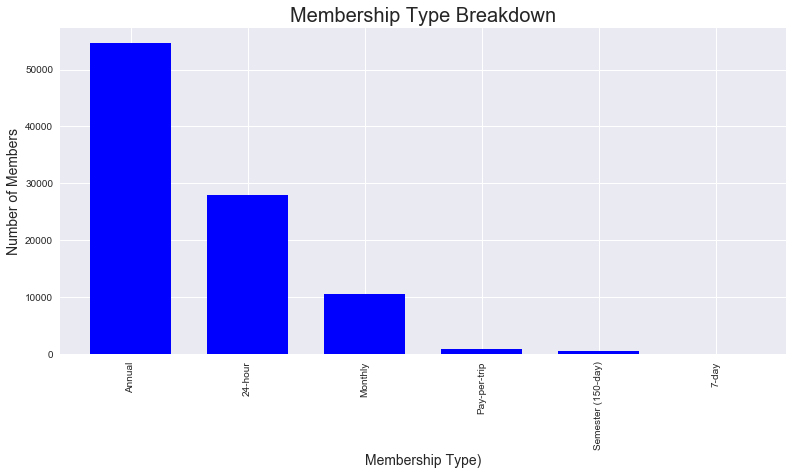

In [63]:
# plot the results
ax = dF.groupby('Membership_Type').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Membership Type Breakdown', fontsize = 20)
plt.xlabel('Membership Type)', fontsize = 14)
plt.ylabel('Number of Members', fontsize = 14)
plt.show()

### Estimate Trip Distance for Kiosks that have the same starting and ending trip information

In [64]:
dF.rename(columns = {'Average_Distance' : 'Trip_Distance'}, inplace = True)

In [65]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,00:48:00,15th & Pearl,2016-01-01,01:10:00,UCAR Mitchell Lane,22,3.115
1,Boulder B-cycle,R1055645,Annual,578,2016-01-01,04:08:00,26th @ Pearl,2016-01-01,04:17:00,14th & Canyon,9,1.130
2,Boulder B-cycle,R1070183,Annual,763,2016-01-01,09:56:00,38th & Arapahoe,2016-01-01,10:10:00,Municipal Building,14,2.240


In [66]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94319 entries, 0 to 94511
Data columns (total 12 columns):
User_Program       94319 non-null object
User_ID            94319 non-null object
Membership_Type    94319 non-null object
Bike_Number        94319 non-null object
Checkout_Date      94319 non-null datetime64[ns]
Checkout_Time      94319 non-null object
Checkout_Kiosk     94319 non-null object
Return_Date        94319 non-null datetime64[ns]
Return_Time        94319 non-null object
Return_Kiosk       94319 non-null object
Trip_Duration      94319 non-null int64
Trip_Distance      94319 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 9.4+ MB


In [67]:
# Valid data that needs to aggregated to total distance
dD = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Distance"] == 0)]

In [68]:
# valid data rows = 8992
dD.shape

(9279, 12)

In [69]:
dD.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
20,Boulder B-cycle,R1005561,Annual,515,2016-01-01,14:53:00,30th & Glenwood,2016-01-01,15:08:00,30th & Glenwood,15,0.000
44,Boulder B-cycle,R1005561,Annual,515,2016-01-02,09:14:00,30th & Glenwood,2016-01-02,09:42:00,30th & Glenwood,28,0.000
63,Boulder B-cycle,R1066166,24-hour,728,2016-01-02,13:48:00,Wilderness Place,2016-01-02,14:22:00,Wilderness Place,34,0.000


In [70]:
dD['Trip_Duration'].sum()

503838

In [71]:
dF['Trip_Duration'].sum() - dD['Trip_Duration'].sum()

1736058

In [72]:
dF['Trip_Distance'].sum()

110838.65500001202

### Estimate average speed for use in Kiosks that have the same and ending trip infomation

In [73]:
avSpeed =  (dF['Trip_Distance'].sum()) /(dF['Trip_Duration'].sum() - dD['Trip_Duration'].sum())

In [74]:
avSpeed # miles/min

0.06384501842681063

In [75]:
dE = dD.copy(deep=True)

In [76]:
# Multiply the trip duration by average speed to get distance
dE['Trip_Distance'] = dE['Trip_Duration'].map(lambda x: x*avSpeed)

In [77]:
# drop columns that are not relevant to the merge with the Trips dataframe
dE.drop(dE.columns[[0,1,2,3,4,5,6,7,8,9,10]], axis=1, inplace=True)

In [78]:
dE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9279 entries, 20 to 94493
Data columns (total 1 columns):
Trip_Distance    9279 non-null float64
dtypes: float64(1)
memory usage: 145.0 KB


In [79]:
# merge the 9279 rows into the 94,319 rows of the main dataframe
dF = pd.merge(dF, dE, how = 'left', left_index=True, right_index= True)

In [80]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94319 entries, 0 to 94511
Data columns (total 13 columns):
User_Program       94319 non-null object
User_ID            94319 non-null object
Membership_Type    94319 non-null object
Bike_Number        94319 non-null object
Checkout_Date      94319 non-null datetime64[ns]
Checkout_Time      94319 non-null object
Checkout_Kiosk     94319 non-null object
Return_Date        94319 non-null datetime64[ns]
Return_Time        94319 non-null object
Return_Kiosk       94319 non-null object
Trip_Duration      94319 non-null int64
Trip_Distance_x    94319 non-null float64
Trip_Distance_y    9279 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1), object(8)
memory usage: 10.1+ MB


In [81]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance_x,Trip_Distance_y
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,00:48:00,15th & Pearl,2016-01-01,01:10:00,UCAR Mitchell Lane,22,3.115,nan
1,Boulder B-cycle,R1055645,Annual,578,2016-01-01,04:08:00,26th @ Pearl,2016-01-01,04:17:00,14th & Canyon,9,1.130,nan
2,Boulder B-cycle,R1070183,Annual,763,2016-01-01,09:56:00,38th & Arapahoe,2016-01-01,10:10:00,Municipal Building,14,2.240,nan


In [82]:
# convert the NaN values to numeric and fill them with zeros
dF[['Trip_Distance_y']] = dF[['Trip_Distance_y']].apply(pd.to_numeric)
dF['Trip_Distance_y'].fillna(0, inplace=True)

In [83]:
# update the distance values in the main dataframe
dF['Trip_Distance'] = dF['Trip_Distance_x'] + dF['Trip_Distance_y']

In [84]:
dF.drop(['Trip_Distance_x'], axis = 1, inplace=True)

In [85]:
dF.drop(['Trip_Distance_y'], axis = 1, inplace=True)

In [86]:
totalDistance = dF['Trip_Distance'].sum()

### Distance Traveled = 143,006 miles

Boulder Bike Sharing 2016 Annual Report records estimated miles ridden = **229,071**. This report shows **143,006** miles ridden, a delta of **86,065** or **37%**.

In [87]:
totalDistance

143006.20139413525

### Most Popular Checkout Kiosks

In [88]:
# Most popular Checkout Kiosks
mostPopular = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False)

In [89]:
mostPopular.head(10)

Checkout_Kiosk
15th & Pearl          5443
13th & Spruce         4272
Municipal Building    3666
11th & Pearl          3566
Folsom & Colorado     3565
13th & Arapahoe       3392
20th & Pearl          3327
Broadway & Alpine     3147
31st & Pearl          2976
Broadway & Euclid     2968
dtype: int64

### Most Popular Checkout Kiosk to Return Kiosk Routes

In [90]:
cK_rK = dF.groupby(['Checkout_Kiosk', 'Return_Kiosk']).size().to_frame(name = 'Number_Of_Trips').reset_index()

In [91]:
cK_rK.sort_values(by='Number_Of_Trips', ascending=[False]).head(10)

,Checkout_Kiosk,Return_Kiosk,Number_Of_Trips
144,13th & Spruce,Broadway & Alpine,724
971,Broadway & Alpine,13th & Spruce,695
922,6th & Canyon,Municipal Building,680
1335,Municipal Building,6th & Canyon,641
294,20th & Pearl,15th & Pearl,604
1346,Municipal Building,Municipal Building,566
503,28th & Mapleton,26th @ Pearl,552
1220,Folsom & Pearl,15th & Pearl,529
42,13th & Arapahoe,13th & Arapahoe,506
211,15th & Pearl,20th & Pearl,503


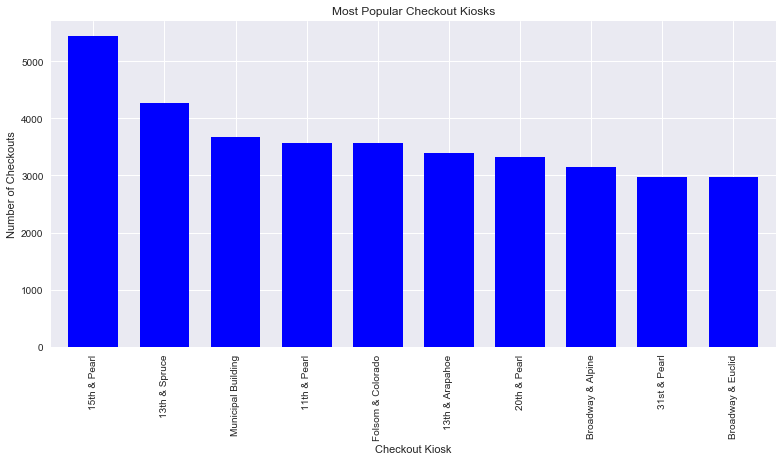

In [92]:
# plot the results
ax = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Most Popular Checkout Kiosks")
plt.xlabel('Checkout Kiosk')
plt.ylabel('Number of Checkouts')
plt.show()

### Map of Checkout Kiosk Popularity

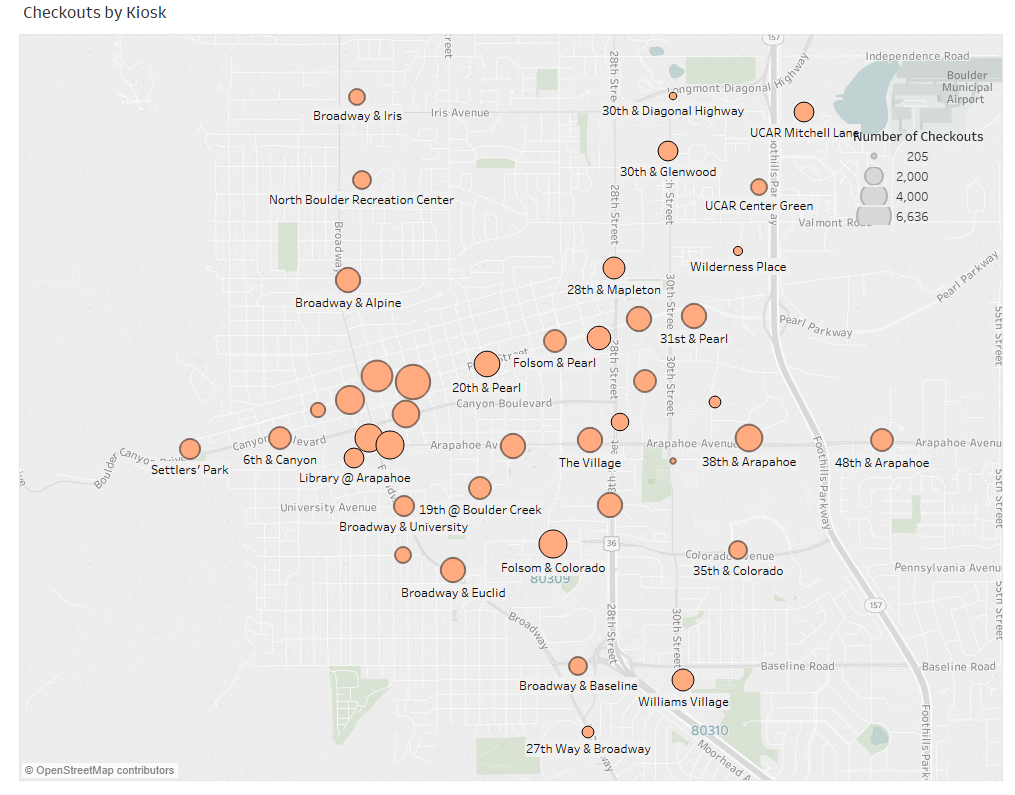

In [93]:
from IPython.display import Image
image = Image('figures/Figure 2.png')
image

### Most Popular Return Kiosks

In [94]:
# Most popular Return Kiosks
mostPopular = dF.groupby('Return_Kiosk').size().sort_values(ascending=False)

In [95]:
mostPopular.head(10)

Return_Kiosk
15th & Pearl          5366
13th & Spruce         4909
Municipal Building    3919
13th & Arapahoe       3898
11th & Pearl          3737
29th & Pearl          3260
21st & Arapahoe       3178
14th & Canyon         3102
20th & Pearl          3055
Broadway & Alpine     3040
dtype: int64

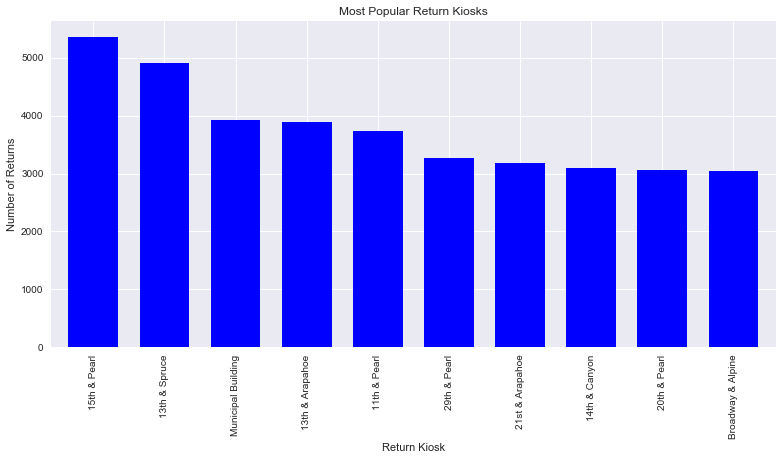

In [96]:
# plot the results
ax = dF.groupby('Return_Kiosk').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Most Popular Return Kiosks")
plt.xlabel('Return Kiosk')
plt.ylabel('Number of Returns')
plt.show()

### Map of Return Kiosk Popularity

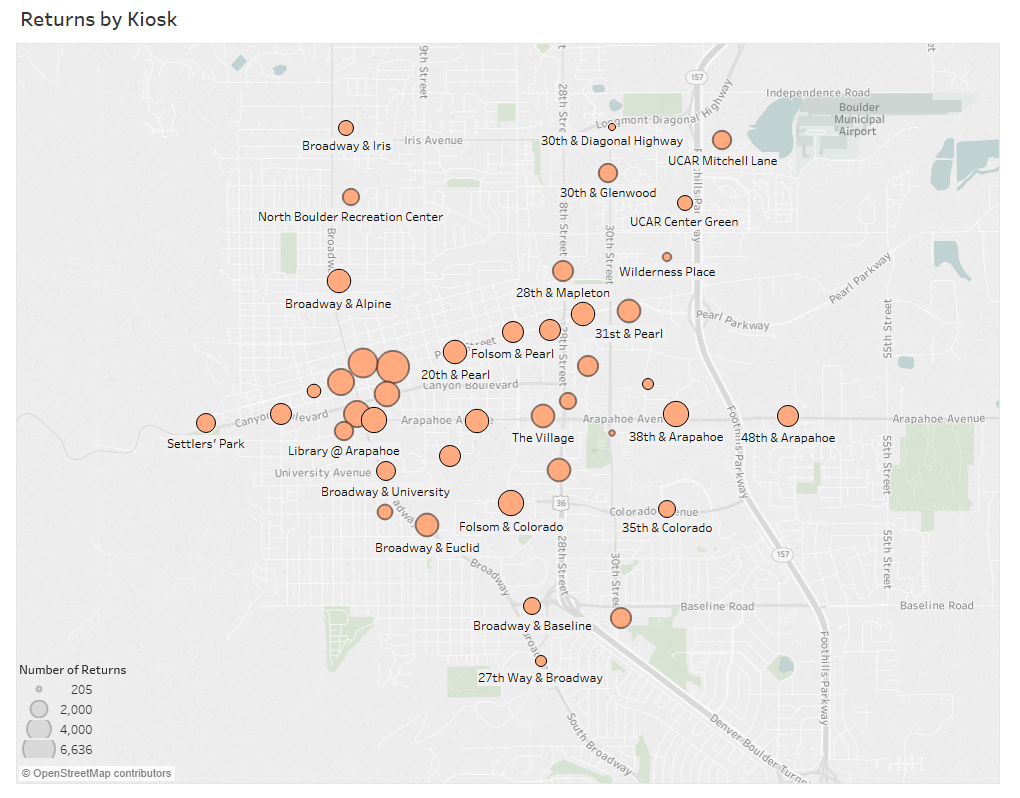

In [97]:
image = Image('figures/Figure 3.png')
image

### Least Popular Checkout Kiosks

In [98]:
# Least popular Checkout Kiosks
leastPopular = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False)

In [99]:
leastPopular.tail(10)

Checkout_Kiosk
Broadway & Iris            1328
13th & College             1299
UCAR Center Green          1227
9th & Pearl                 982
27th Way & Broadway         678
33rd & Fisher               648
Wilderness Place            370
30th & Diagonal Highway     247
30th & Marine               159
Gunbarrel North             120
dtype: int64

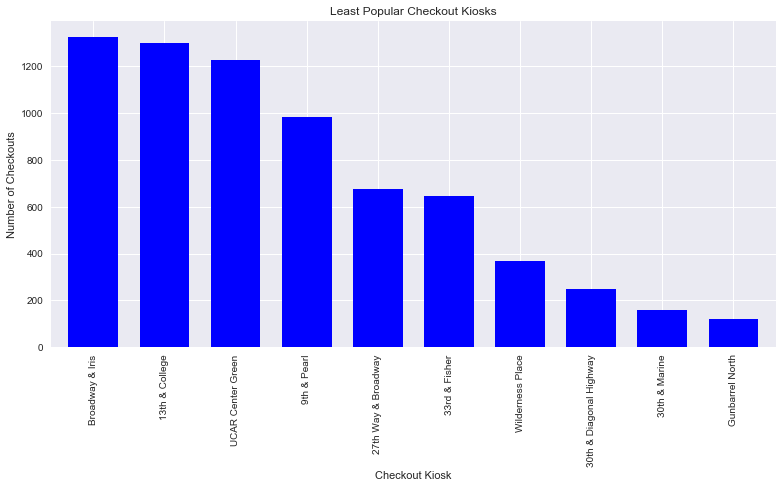

In [100]:
# plot the results
ax = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False).tail(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Least Popular Checkout Kiosks")
plt.xlabel('Checkout Kiosk')
plt.ylabel('Number of Checkouts')
plt.show()

### Least Popular Return Kiosks

In [101]:
# Least popular Return Kiosks
leastPopular = dF.groupby('Return_Kiosk').size().sort_values(ascending=False)

In [102]:
leastPopular.tail(10)

Return_Kiosk
Broadway & University      1265
Broadway & Iris            1070
9th & Pearl                 963
13th & College              804
33rd & Fisher               708
27th Way & Broadway         509
Wilderness Place            426
30th & Diagonal Highway     263
30th & Marine               170
Gunbarrel North             114
dtype: int64

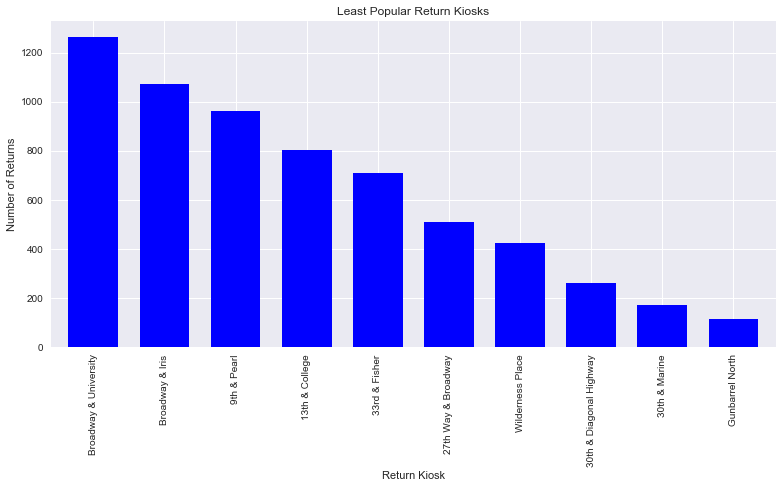

In [103]:
# plot the results
ax = dF.groupby('Return_Kiosk').size().sort_values(ascending=False).tail(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Least Popular Return Kiosks")
plt.xlabel('Return Kiosk')
plt.ylabel('Number of Returns')
plt.show()

In [104]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,00:48:00,15th & Pearl,2016-01-01,01:10:00,UCAR Mitchell Lane,22,3.115
1,Boulder B-cycle,R1055645,Annual,578,2016-01-01,04:08:00,26th @ Pearl,2016-01-01,04:17:00,14th & Canyon,9,1.130
2,Boulder B-cycle,R1070183,Annual,763,2016-01-01,09:56:00,38th & Arapahoe,2016-01-01,10:10:00,Municipal Building,14,2.240


In [105]:
dF.rename(columns = {'Checkout_Time' : 'Checkout_Hour'}, inplace = True)

### Convert Checkout Time to Checkout_Hour

In [106]:
dF['Checkout_Hour'] = dF['Checkout_Hour'].map(lambda x: x[:2]).astype(int)

In [107]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,0,15th & Pearl,2016-01-01,01:10:00,UCAR Mitchell Lane,22,3.115
1,Boulder B-cycle,R1055645,Annual,578,2016-01-01,4,26th @ Pearl,2016-01-01,04:17:00,14th & Canyon,9,1.130
2,Boulder B-cycle,R1070183,Annual,763,2016-01-01,9,38th & Arapahoe,2016-01-01,10:10:00,Municipal Building,14,2.240


### Ridership by Calendar and Clock Variables

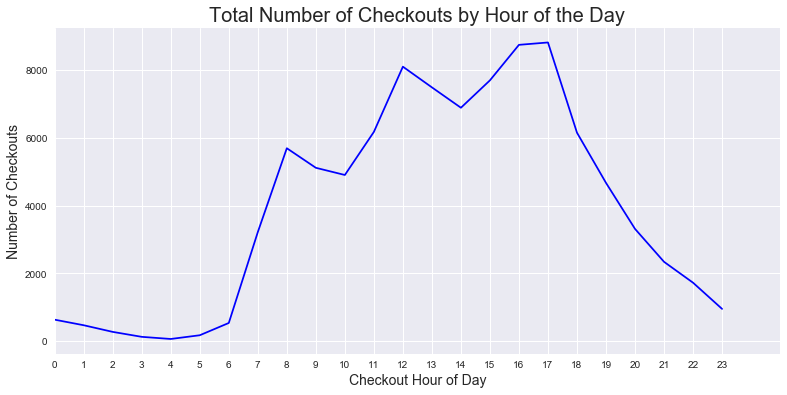

In [108]:
# plot the results
ax = dF.groupby('Checkout_Hour').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,25))
plt.title('Total Number of Checkouts by Hour of the Day', fontsize = 20)
plt.xlabel('Checkout Hour of Day', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.xticks(np.arange(0, 24, 1.0))
plt.show()

In [109]:
dH = dF.groupby(['Checkout_Hour']).mean()

In [110]:
dH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 2 columns):
Trip_Duration    24 non-null float64
Trip_Distance    24 non-null float64
dtypes: float64(2)
memory usage: 576.0 bytes


In [111]:
dH.drop(['Trip_Duration'], axis=1, inplace=True)

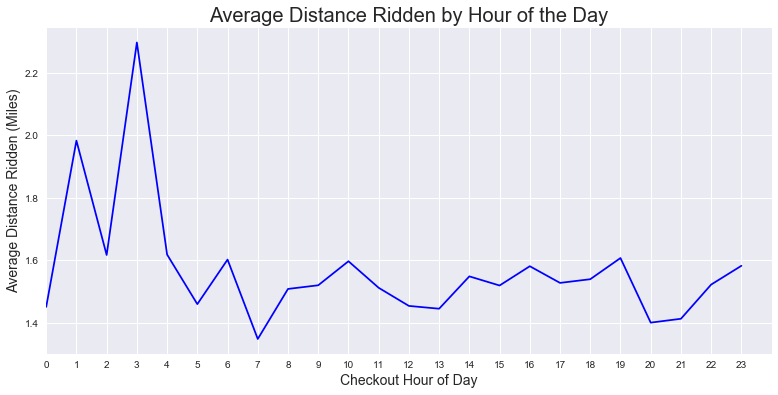

In [112]:
ax = dH.plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,24))
plt.title('Average Distance Ridden by Hour of the Day', fontsize = 20)
plt.xlabel('Checkout Hour of Day', fontsize = 14)
plt.ylabel('Average Distance Ridden (Miles)', fontsize = 14)
plt.xticks(np.arange(0, 24, 1.0))
ax.legend().set_visible(False)
plt.show()

### Ridership by Hour and Weekday

#### Create Checkout_Weekday Column in Weather dataframe

In [113]:
# Create a new column called Checkout_WeekDay
dF['Checkout_WeekDay'] = pd.DatetimeIndex(dF['Checkout_Date']).weekday

In [114]:
dMon = dF.where(dF['Checkout_WeekDay'] == 0)
dTue = dF.where(dF['Checkout_WeekDay'] == 1)
dWed = dF.where(dF['Checkout_WeekDay'] == 2)
dThu = dF.where(dF['Checkout_WeekDay'] == 3)
dFri = dF.where(dF['Checkout_WeekDay'] == 4)
dSat = dF.where(dF['Checkout_WeekDay'] == 5)
dSun = dF.where(dF['Checkout_WeekDay'] == 6)

In [115]:
axMon = dMon.groupby('Checkout_Hour').size()
axTue = dTue.groupby('Checkout_Hour').size()
axWed = dWed.groupby('Checkout_Hour').size()
axThu = dThu.groupby('Checkout_Hour').size()
axFri = dFri.groupby('Checkout_Hour').size()
axSat = dSat.groupby('Checkout_Hour').size()
axSun = dSun.groupby('Checkout_Hour').size()

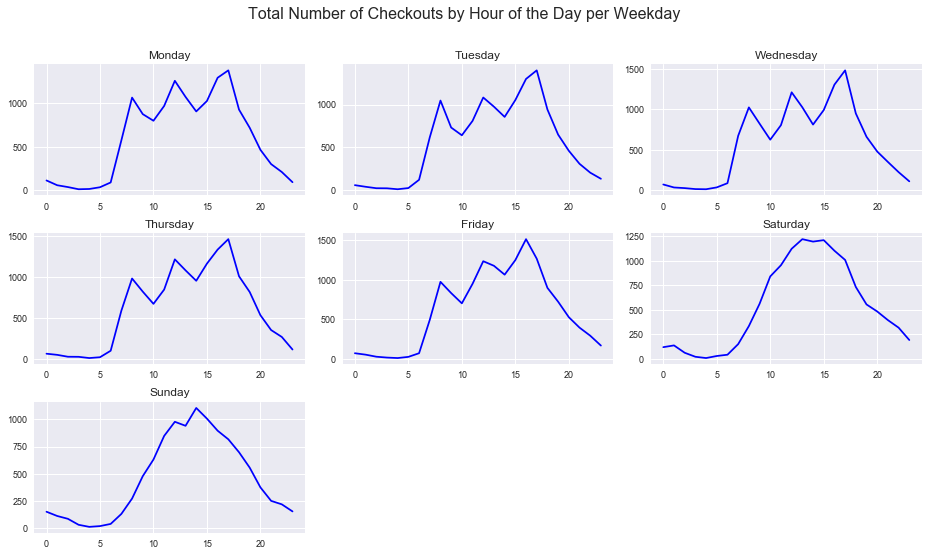

In [116]:
# plot the results
plt.figure()
plt.figure(figsize=(13,10))
plt.suptitle('Total Number of Checkouts by Hour of the Day per Weekday', fontsize=16)

#plt.xlabel('xlabel', fontsize=10)
#plt.ylabel('ylabel', fontsize=10)
plt.subplot(4,3,1)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Monday', fontsize=12)
plt.plot(axMon,'b-')

plt.subplot(4,3,2)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Tuesday', fontsize=12)
plt.plot(axTue,'b-')

plt.subplot(4,3,3)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Wednesday', fontsize=12)
plt.plot(axWed,'b-')

plt.subplot(4,3,4)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Thursday', fontsize=12)
plt.plot(axThu,'b-')

plt.subplot(4,3,5)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)  
plt.title('Friday', fontsize=12)
plt.plot(axFri,'b-')

plt.subplot(4,3,6)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Saturday', fontsize=12)
plt.plot(axSat,'b-')

plt.subplot(4,3,7)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Sunday', fontsize=12)
plt.plot(axSun,'b-')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig = plt.gca()

### Ridership by Month

#### Create Checkout_Month column in Trips dataframe

In [117]:
# Create a new column called Checkout_Month
dF['Checkout_Month'] = pd.DatetimeIndex(dF['Checkout_Date']).month

In [118]:
dM = dF.groupby(['Checkout_Month'])

In [119]:
dM.size()

Checkout_Month
1      3616
2      4366
3      4916
4      5853
5      8337
6     11660
7     13507
8     12806
9     10363
10     8975
11     6567
12     3353
dtype: int64

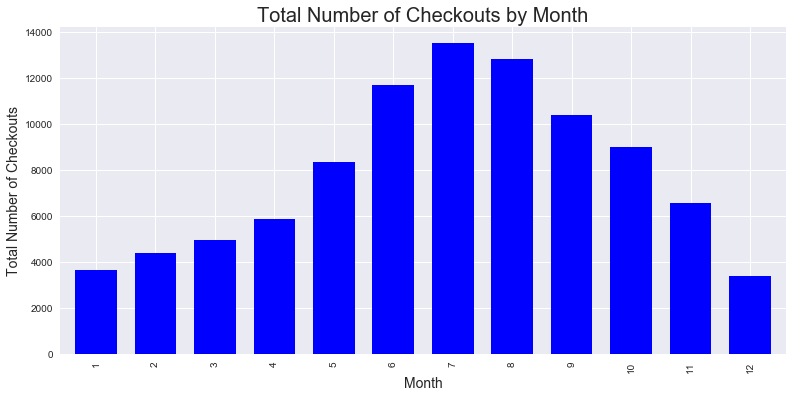

In [120]:
# plot the results
ax = dF.groupby('Checkout_Month').size().plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Total Number of Checkouts by Month', fontsize = 20)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Total Number of Checkouts', fontsize = 14)
plt.show()

## Merging with Weather

### Merge Daily Weather Data with Trips DataFrame

In [121]:
dW = pd.read_csv("data/Boulder_2016_Daily_Weather_Forecast.csv")

In [122]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 9 columns):
Date                      366 non-null object
cloudCover                366 non-null float64
apparentTemperatureMax    366 non-null float64
apparentTemperatureMin    366 non-null float64
temperatureMax            366 non-null float64
temperatureMin            366 non-null float64
windSpeed                 366 non-null float64
humidity                  366 non-null float64
visibility                366 non-null float64
dtypes: float64(8), object(1)
memory usage: 25.8+ KB


In [123]:
dW.head(3)

,Date,cloudCover,apparentTemperatureMax,apparentTemperatureMin,temperatureMax,temperatureMin,windSpeed,humidity,visibility
0,2016-01-01,0.010,32.150,-2.510,32.150,4.440,2.590,0.580,9.790
1,2016-01-02,0.030,39.820,6.530,39.820,13.130,2.300,0.440,9.980
2,2016-01-03,0.050,40.810,15.700,40.810,18.970,1.020,0.500,9.990


In [124]:
dW.isnull().values.any()

False

In [125]:
dW['Date'] = pd.to_datetime(dW['Date'])

In [126]:
dW.sort_values(['Date'], inplace=True)

In [127]:
#dW.drop(['cloudCover', 'windSpeed', 'humidity'], axis = 1, inplace=True)

In [128]:
dF = pd.merge(dF, dW, how='left', left_on=['Checkout_Date'], right_on=['Date'])

In [129]:
dF.shape

(94319, 23)

In [130]:
dF.isnull().values.any()

False

In [131]:
dF.drop(['Date'], axis = 1, inplace = True)

In [132]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94319 entries, 0 to 94318
Data columns (total 22 columns):
User_Program              94319 non-null object
User_ID                   94319 non-null object
Membership_Type           94319 non-null object
Bike_Number               94319 non-null object
Checkout_Date             94319 non-null datetime64[ns]
Checkout_Hour             94319 non-null int32
Checkout_Kiosk            94319 non-null object
Return_Date               94319 non-null datetime64[ns]
Return_Time               94319 non-null object
Return_Kiosk              94319 non-null object
Trip_Duration             94319 non-null int64
Trip_Distance             94319 non-null float64
Checkout_WeekDay          94319 non-null int32
Checkout_Month            94319 non-null int32
cloudCover                94319 non-null float64
apparentTemperatureMax    94319 non-null float64
apparentTemperatureMin    94319 non-null float64
temperatureMax            94319 non-null float64
temperatur

### Ridership by Day

Plot above shows temperature affects ridership. Daily temperatures in the 70s to 80s result in the highest ridership while temperatures 35F and below result in the lowest ridership. Also, ridership is high on weekends (Sunday, labeled as 6 and Saturday, labeled as 5) and during the months between May and June. Conversely, the winter months (December to February) have the lowest ridership unless the temperature is favorable on those days, which is typical of Colorado.

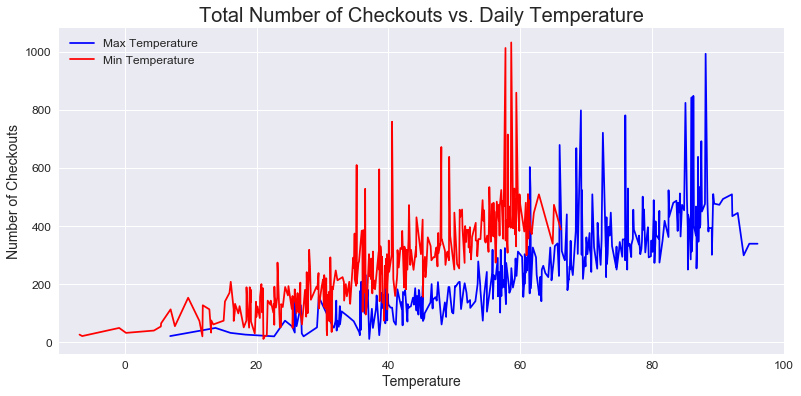

In [133]:
ax = dF.groupby('temperatureMax').size().plot(kind='line', figsize=(13,6), 
                color='blue', label='Max Temperature', fontsize=12, xlim=(-10,100))
ax = dF.groupby('temperatureMin').size().plot(kind='line', figsize=(13,6), 
                color='red', label='Min Temperature', fontsize=12, xlim=(-10,100))
plt.title('Total Number of Checkouts vs. Daily Temperature', fontsize = 20)
plt.xlabel('Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

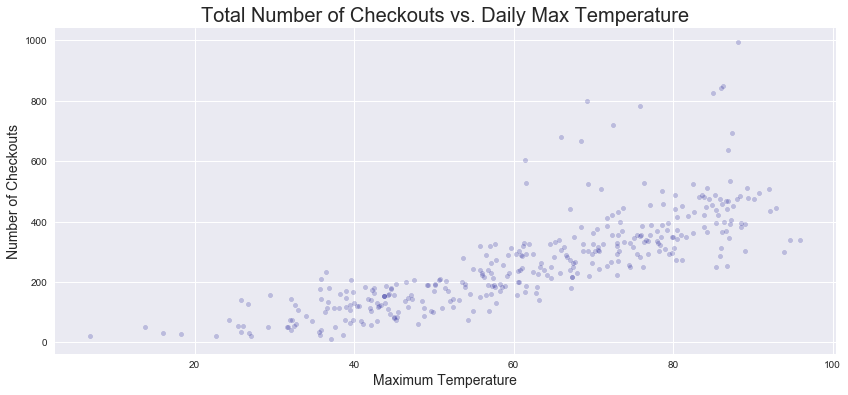

In [134]:
ax = dF.groupby(['temperatureMax']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='temperatureMax', y='Number_Of_Checkouts', alpha=0.2, figsize=(14,6), color='DarkBlue')
plt.title('Total Number of Checkouts vs. Daily Max Temperature', fontsize = 20)
plt.xlabel('Maximum Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

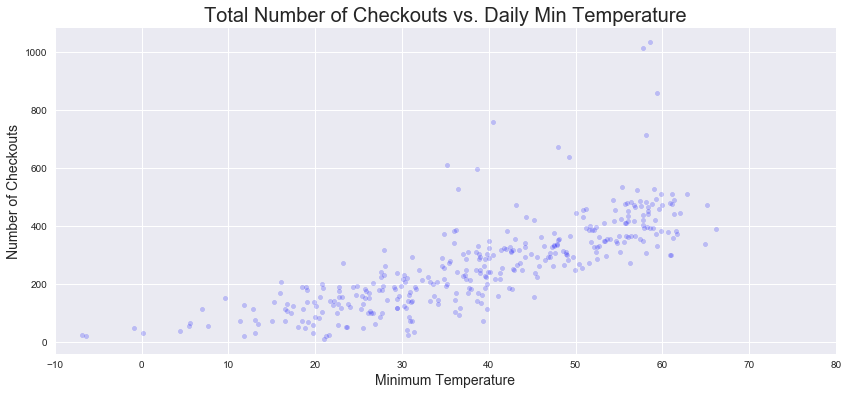

In [135]:
ax = dF.groupby(['temperatureMin']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='temperatureMin', y='Number_Of_Checkouts', alpha=0.2, figsize=(14,6),
        color='blue', xlim=(-10,80))
plt.title('Total Number of Checkouts vs. Daily Min Temperature', fontsize = 20)
plt.xlabel('Minimum Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

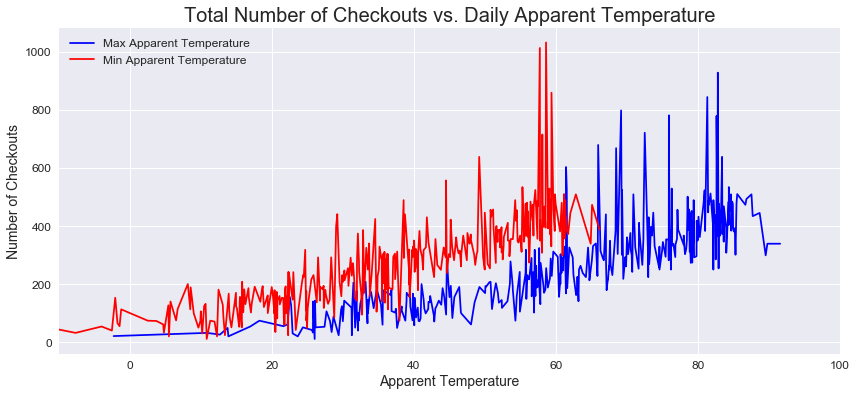

In [136]:
ax = dF.groupby('apparentTemperatureMax').size().plot(kind='line', figsize=(14,6), 
                color='blue', label='Max Apparent Temperature', fontsize=12, xlim=(-10,100))
ax = dF.groupby('apparentTemperatureMin').size().plot(kind='line', figsize=(14,6), 
                color='red', label='Min Apparent Temperature', fontsize=12, xlim=(-10,100))
plt.title('Total Number of Checkouts vs. Daily Apparent Temperature', fontsize = 20)
plt.xlabel('Apparent Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

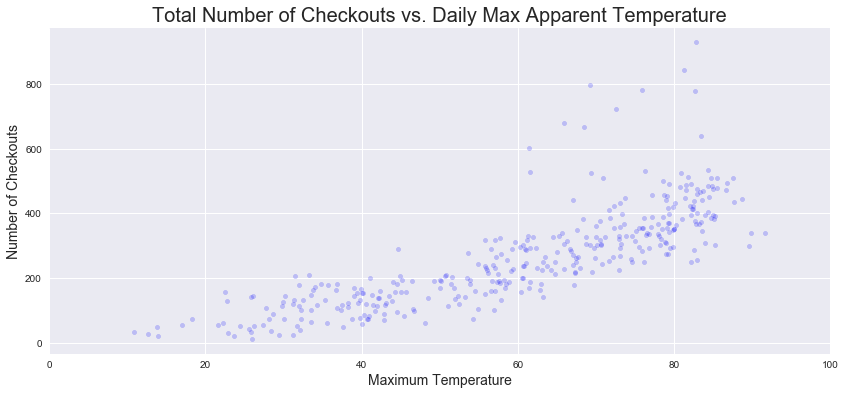

In [137]:
ax = dF.groupby(['apparentTemperatureMax']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='apparentTemperatureMax', y='Number_Of_Checkouts', alpha=0.2, figsize=(14,6),
        color='blue', xlim=(0,100))
plt.title('Total Number of Checkouts vs. Daily Max Apparent Temperature', fontsize = 20)
plt.xlabel('Maximum Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

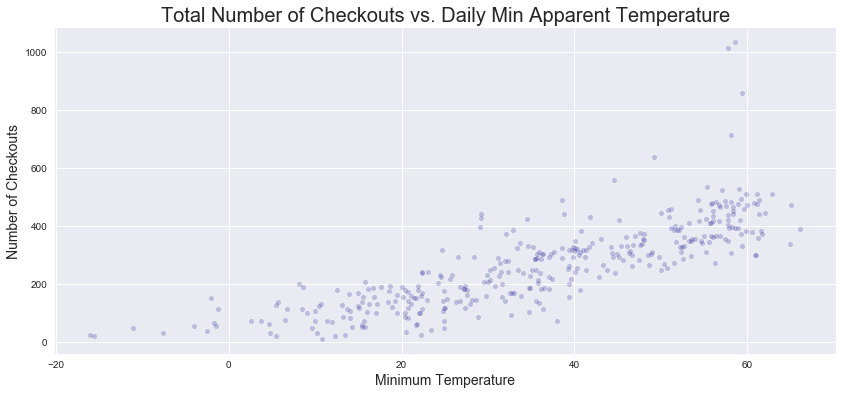

In [138]:
ax = dF.groupby(['apparentTemperatureMin']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='apparentTemperatureMin', y='Number_Of_Checkouts', alpha=0.2, figsize=(14,6), color='DarkBlue')
plt.title('Total Number of Checkouts vs. Daily Min Apparent Temperature', fontsize = 20)
plt.xlabel('Minimum Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

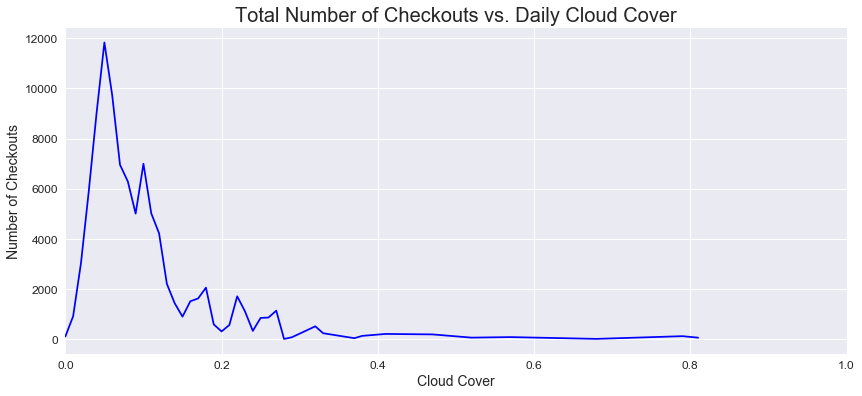

In [139]:
ax = dF.groupby('cloudCover').size().plot(kind='line', figsize=(14,6), 
                color='blue', fontsize=12, xlim=(0,1))
plt.title('Total Number of Checkouts vs. Daily Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

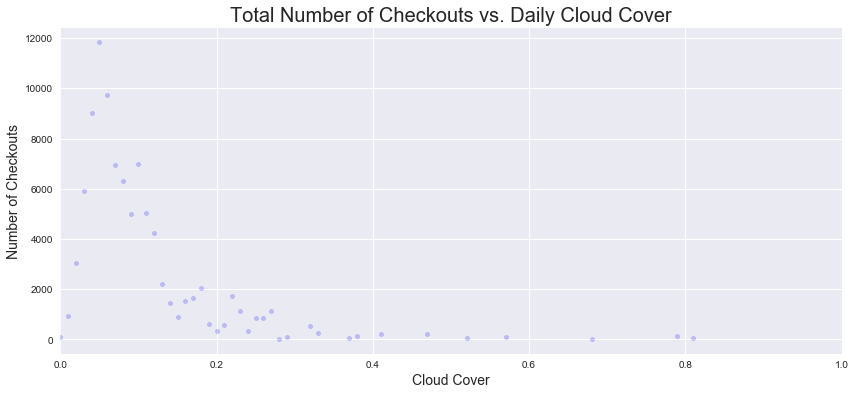

In [140]:
ax = dF.groupby(['cloudCover']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='cloudCover', y='Number_Of_Checkouts', alpha=0.2, figsize=(14,6),
        color='blue', xlim=(0,1))
plt.title('Total Number of Checkouts vs. Daily Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

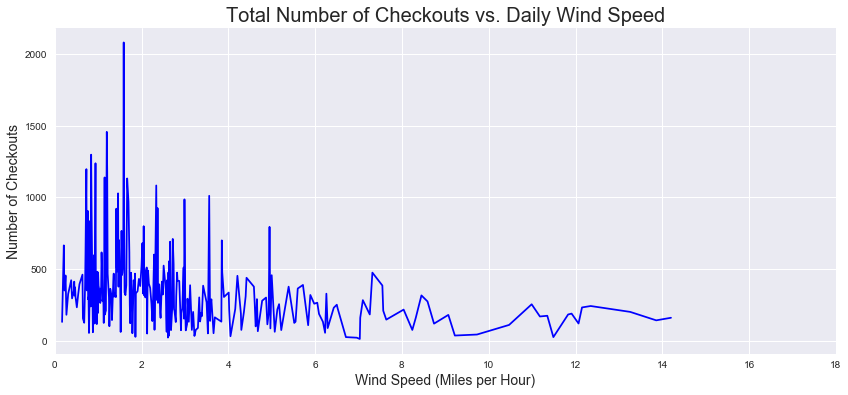

In [141]:
ax = dF.groupby('windSpeed').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0,18))
plt.title('Total Number of Checkouts vs. Daily Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

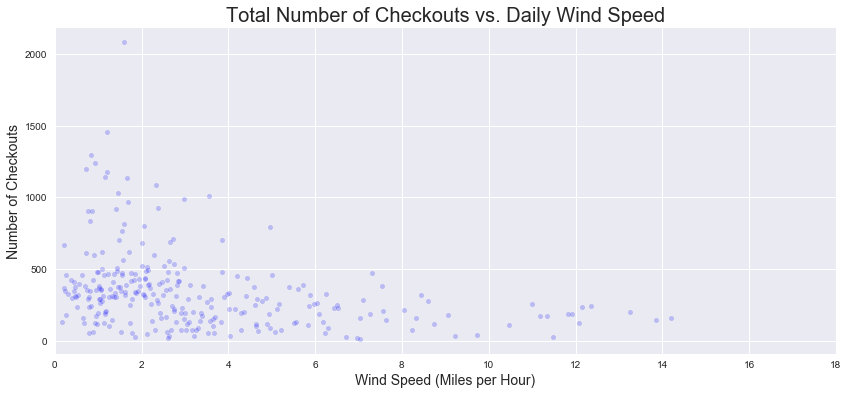

In [142]:
ax = dF.groupby(['windSpeed']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='windSpeed', y='Number_Of_Checkouts', alpha=0.2, figsize=(14,6),
        color='blue', xlim=(0,18))
plt.title('Total Number of Checkouts vs. Daily Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

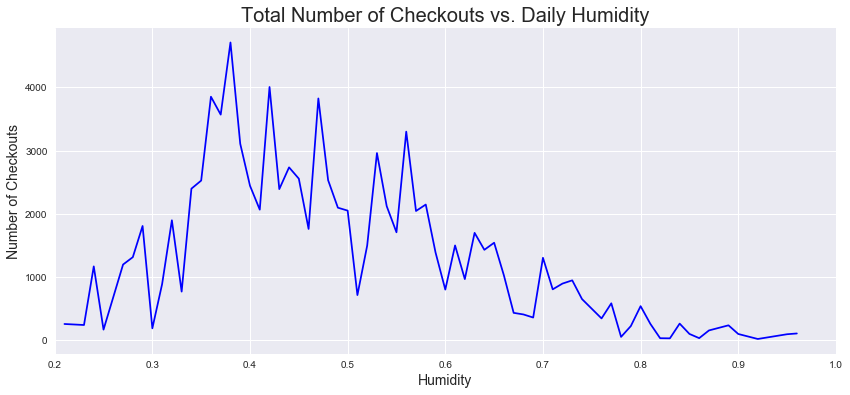

In [143]:
ax = dF.groupby('humidity').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0.2,1))
plt.title('Total Number of Checkouts vs. Daily Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

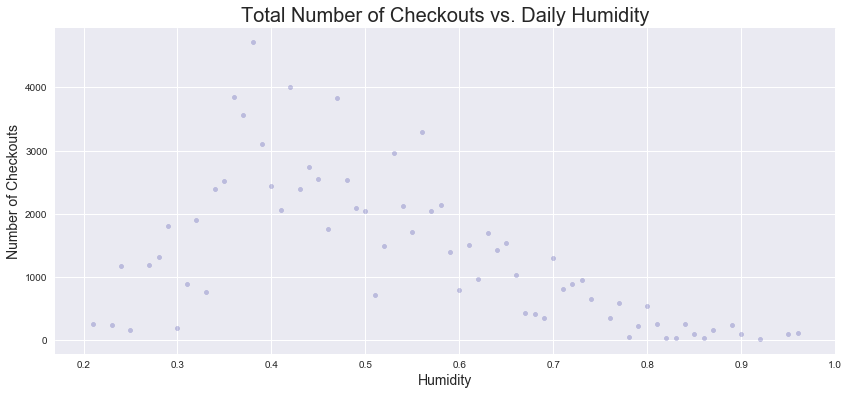

In [144]:
ax = dF.groupby(['humidity']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='humidity', y='Number_Of_Checkouts', alpha=0.2, figsize=(14,6), color='DarkBlue')
plt.title('Total Number of Checkouts vs. Daily Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

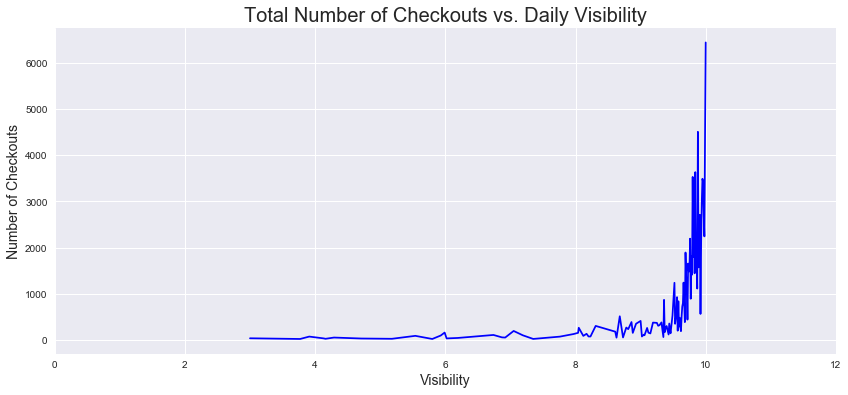

In [145]:
ax = dF.groupby('visibility').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0,12))
plt.title('Total Number of Checkouts vs. Daily Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

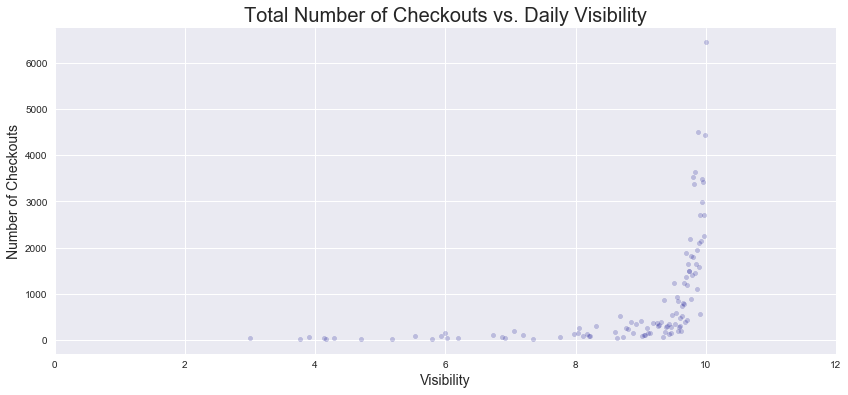

In [146]:
ax = dF.groupby(['visibility']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='visibility', y='Number_Of_Checkouts', alpha=0.2, figsize=(14,6), color='DarkBlue',
        xlim=(0,12))
plt.title('Total Number of Checkouts vs. Daily Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Highest Ridership

In [147]:
dHRD = dF.groupby(['Checkout_WeekDay', 'Checkout_Date', 'temperatureMax', 'temperatureMin'])['Checkout_WeekDay']

In [148]:
dHRD.size().sort_values(ascending=False).head(10)

Checkout_WeekDay  Checkout_Date  temperatureMax  temperatureMin
0                 2016-09-05     86.950          49.210            638
2                 2016-07-27     87.150          55.300            534
5                 2016-08-06     76.320          59.090            529
4                 2016-08-05     69.330          57.110            524
                  2016-07-29     82.480          58.620            523
6                 2016-08-07     84.200          57.750            512
3                 2016-07-21     89.250          61.160            510
0                 2016-08-01     92.090          59.880            509
3                 2016-08-04     70.920          58.620            509
1                 2016-08-02     88.100          62.820            509
dtype: int64

### Lowest Ridership

In [149]:
dHRD.size().sort_values(ascending=False).tail(10)

Checkout_WeekDay  Checkout_Date  temperatureMax  temperatureMin
5                 2016-01-09     25.800          13.110            33
2                 2016-12-07     16.050          0.210             32
4                 2016-03-18     26.860          19.730            30
6                 2016-12-18     18.320          -6.840            26
                  2016-04-17     35.670          30.690            24
2                 2016-03-23     38.610          21.560            24
5                 2016-12-17     6.910           -6.440            21
0                 2016-02-01     27.130          21.230            20
1                 2016-02-02     22.670          11.790            20
6                 2016-12-25     37.090          21.040            11
dtype: int64

In [150]:
dF.drop(['apparentTemperatureMax', 'apparentTemperatureMin', 'temperatureMax', 'temperatureMin',
         'cloudCover', 'humidity', 'windSpeed', 'visibility'], axis = 1, inplace = True)

### Merge Hourly Weather with Trips DataFrame

In [151]:
dW = pd.read_csv("data/Boulder_2016_Hourly_Weather_Forecast.csv")

In [152]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [153]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [154]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [155]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [156]:
dW['Date'] = dW[['Date']].astype('datetime64[ns]')

In [157]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [158]:
dT.isnull().values.any()

True

In [159]:
nan_rows = dT[dT.isnull().T.any().T]

In [160]:
dT = dT.drop(dT.index[nan_rows.index])

In [161]:
dT.isnull().values.any()

False

In [162]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [163]:
dT = dT[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

### Checkouts vs. Hourly Temperature

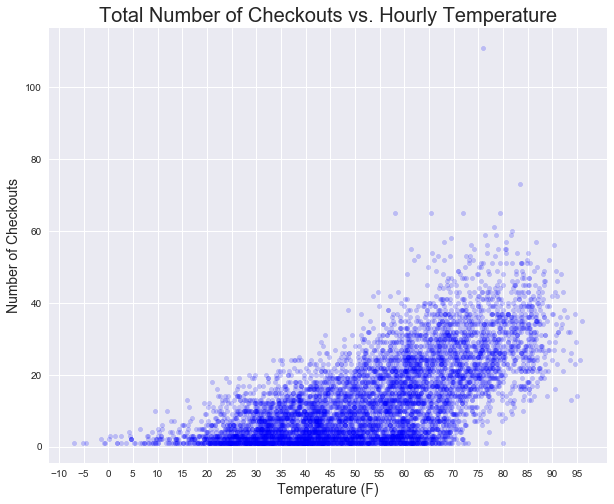

In [164]:
# Pandas scatter plot
dT.plot(kind='scatter', x='Temperature', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(10,8))
plt.title('Total Number of Checkouts vs. Hourly Temperature', fontsize = 20)
plt.xlabel('Temperature (F)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.xticks(np.arange(-10, 100, 5))
plt.show()

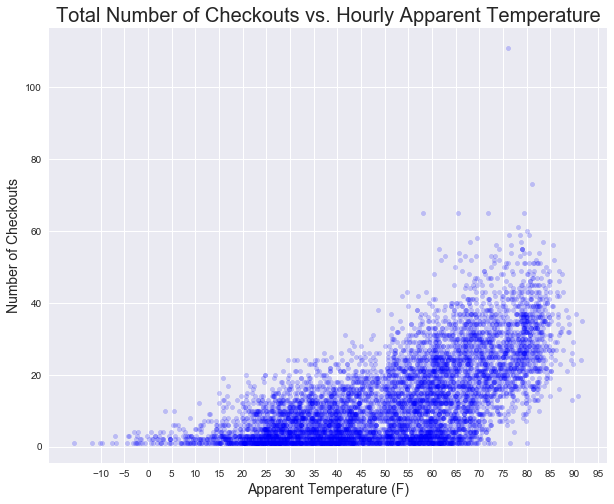

In [165]:
dT.plot(kind='scatter', x='Apparent_Temperature', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(10,8))
plt.title('Total Number of Checkouts vs. Hourly Apparent Temperature', fontsize = 20)
plt.xlabel('Apparent Temperature (F)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.xticks(np.arange(-10, 100, 5))
plt.show()

### Checkouts vs. Hourly Humidity

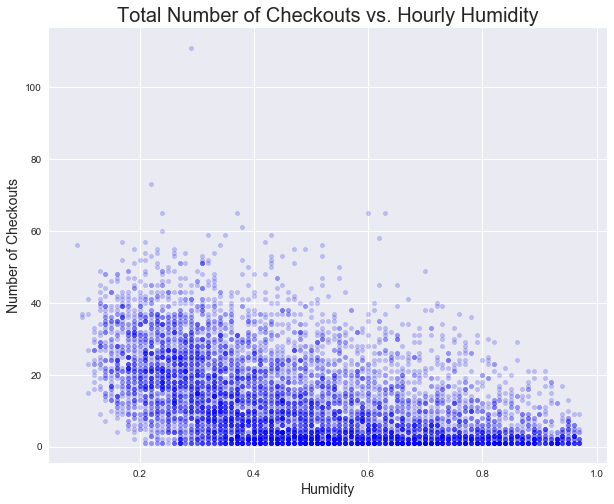

In [166]:
dT.plot(kind='scatter', x='Humidity', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(10,8))
plt.title('Total Number of Checkouts vs. Hourly Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Cloud Cover

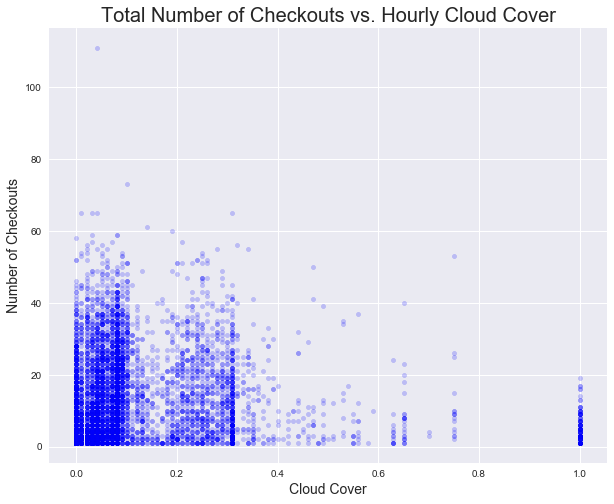

In [167]:
dT.plot(kind='scatter', x='Cloud_Cover', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(10,8))
plt.title('Total Number of Checkouts vs. Hourly Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Wind Speed

Wind speed significantly impacts ridership. Speeds between 0 and 5 miles per hour are very favorable to renting bikes. Rideship radipdly diminshes at 10 or higher miles per hour.

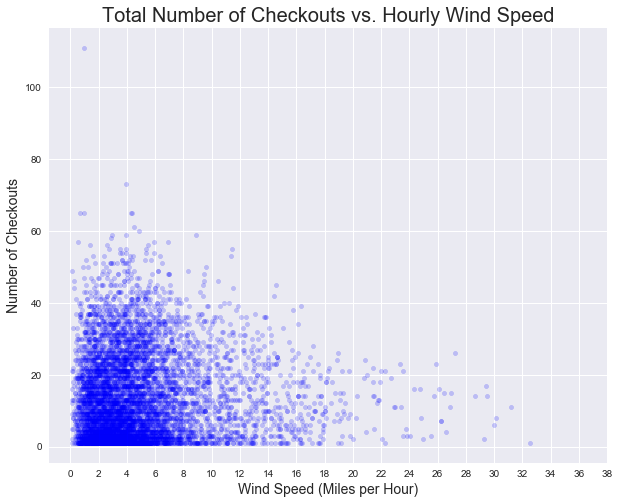

In [168]:
dT.plot(kind='scatter', x='Wind_Speed', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(10,8))
plt.title('Total Number of Checkouts vs. Hourly Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.xticks(np.arange(0, 40, 2))
plt.show()

### Checkouts vs. Hourly Visibility

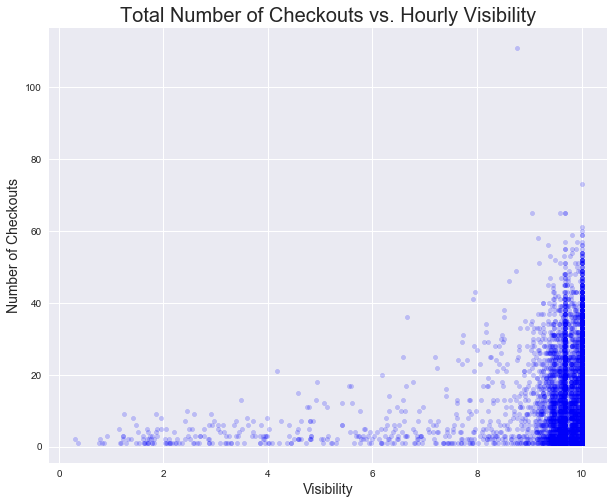

In [169]:
dT.plot(kind='scatter', x='Visibility', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(10,8))
plt.title('Total Number of Checkouts vs. Hourly Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

For regression and classification studies, trip durations of 0, 1 and 2 minutes become relevant, so we need to bring these rows back to the Trips dataframe. Maintenance entries are not valid, so we continue to ignore them.

In [170]:
dML.rename(columns = {'Checkout_Time' : 'Checkout_Hour'}, inplace = True)

In [171]:
dML['Checkout_Hour'] = dML['Checkout_Hour'].map(lambda x: x[:2]).astype(int)

In [172]:
# Create a new column called Checkout_WeekDay
dML['Checkout_WeekDay'] = pd.DatetimeIndex(dML['Checkout_Date']).weekday

In [173]:
# Create a new column called Checkout_Month
dML['Checkout_Month'] = pd.DatetimeIndex(dML['Checkout_Date']).month

In [174]:
dML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98270 entries, 0 to 113727
Data columns (total 13 columns):
User_Program        98270 non-null object
User_ID             98270 non-null object
Membership_Type     98270 non-null object
Bike_Number         98270 non-null object
Checkout_Date       98270 non-null datetime64[ns]
Checkout_Hour       98270 non-null int32
Checkout_Kiosk      98270 non-null object
Return_Date         98270 non-null datetime64[ns]
Return_Time         98270 non-null object
Return_Kiosk        98270 non-null object
Trip_Duration       98270 non-null int64
Checkout_WeekDay    98270 non-null int32
Checkout_Month      98270 non-null int32
dtypes: datetime64[ns](2), int32(3), int64(1), object(7)
memory usage: 9.4+ MB


In [175]:
# save csv file in preparation for use in the Machine Learning phase
dML.to_csv("data/2016_Boulder_Bike_Trip_ML_Data.gz", index=False, compression="gzip")